In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hockey_rink import IIHFRink, Rink, NHLRink

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [121]:
df_games = pd.read_csv('data/Linhac_df_keyed_20_games.csv')

In [122]:
df_games['eventid'] = df_games.index

In [123]:
df_games.eventname.unique()

array(['faceoff', 'lpr', 'pass', 'reception', 'carry', 'controlledexit',
       'dumpin', 'block', 'controlledentryagainst', 'controlledentry',
       'puckprotection', 'shot', 'save', 'rebound', 'dumpout', 'check',
       'penaltydrawn', 'penalty', 'assist', 'goal', 'icing', 'offside',
       'soshot', 'sogoal', 'sopuckprotection'], dtype=object)

In [124]:
df_shots = df_games[df_games.eventname == 'shot'].copy()

In [125]:
df_shots_one_game = df_shots[df_shots.gameid == df_shots.gameid.unique()[0]].copy()

In [126]:
df_games.head()

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg,compiledgametime,eventname,ishomegame,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord,eventid
0,66445,506563.0,916,358235,940804.0,742,NaN,NaN,NaN,0.000000,faceoff,1,evenStrength,5,failed,1,F,0,5,none,0.305008,-0.252941,0
1,66445,940804.0,742,586302,506563.0,916,NaN,NaN,NaN,0.000000,faceoff,0,evenStrength,5,successful,1,F,0,5,recoveredwithentry,-0.305008,0.252941,1
2,66445,506563.0,916,358235,940804.0,742,NaN,NaN,NaN,0.033333,lpr,1,evenStrength,5,failed,1,F,0,5,contested,-0.197929,0.752941,2
3,66445,940804.0,742,689086,506563.0,916,916.0,0.0,NaN,0.100000,lpr,0,evenStrength,5,successful,1,D,0,5,faceoff,-7.849129,-4.776470,3
4,66445,940804.0,742,689086,506563.0,916,916.0,0.0,NaN,0.166667,pass,0,evenStrength,5,successful,1,D,0,5,south,-6.843246,-3.267647,4


In [127]:
df_games.playerprimaryposition.unique()

array(['F', 'D', 'G'], dtype=object)

In [128]:
df_games_goalie_events = df_games.loc[df_games.playerprimaryposition == 'G'].copy()

In [129]:
df_games_goalie_events.eventname.value_counts()

save                      1045
rebound                    614
lpr                        452
pass                       414
controlledentryagainst      43
controlledexit              22
dumpout                     15
block                       15
reception                    9
check                        6
puckprotection               3
penaltydrawn                 3
assist                       2
icing                        1
Name: eventname, dtype: int64

In [130]:
df_goalie_passes = df_games_goalie_events[df_games_goalie_events.eventname == 'pass'].copy()

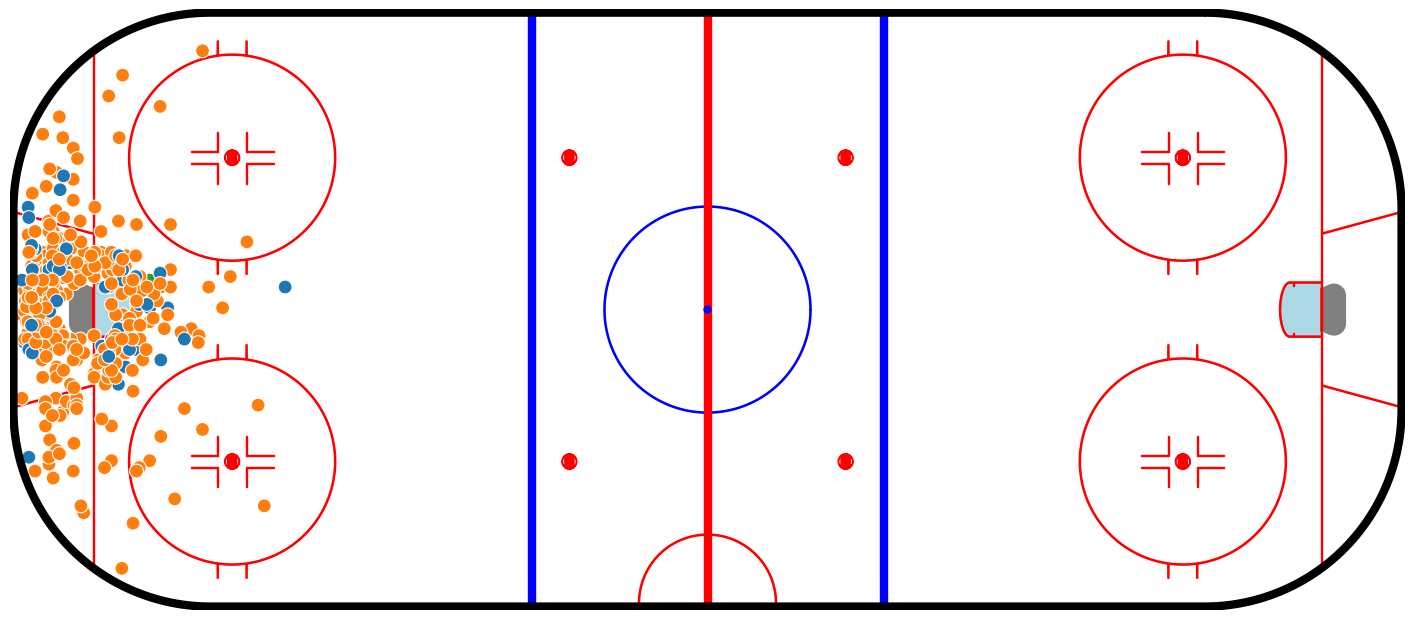

In [131]:
rink = NHLRink()

fig, ax = plt.subplots(figsize=(18, 8))
rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=False, data=df_goalie_passes, ax=ax, hue='outcome')
plt.show()

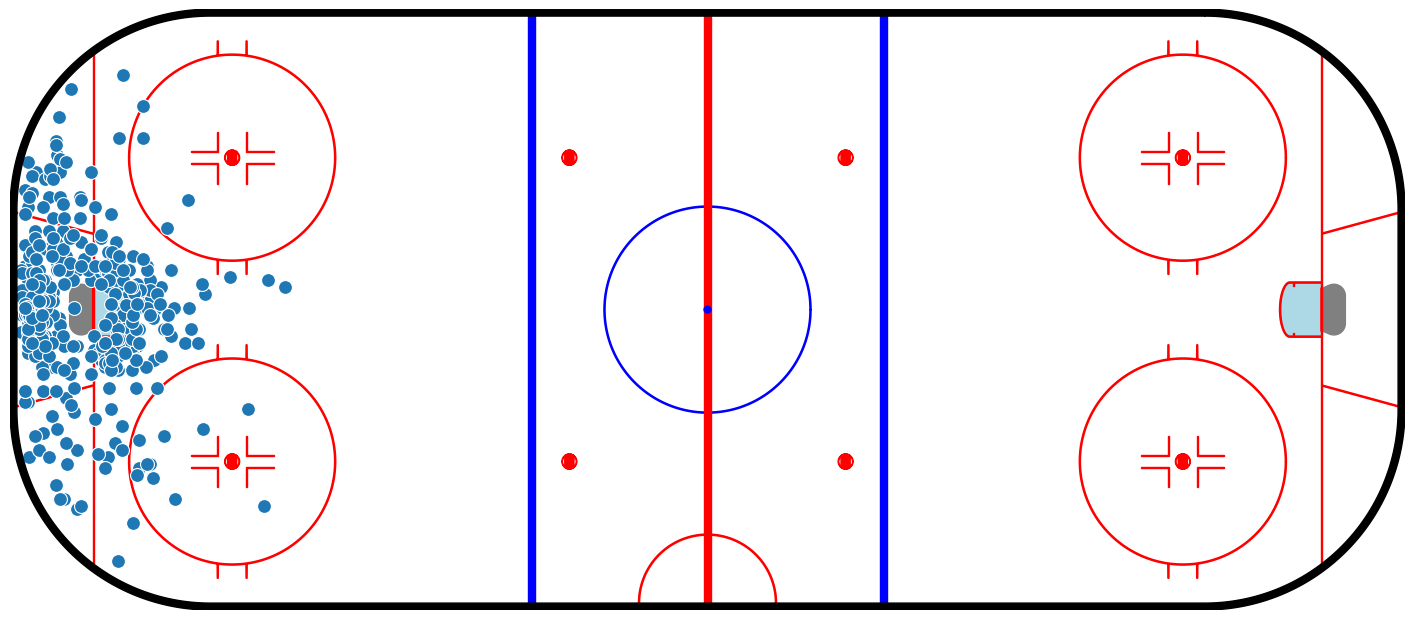

In [132]:
rink = NHLRink()

fig, ax = plt.subplots(figsize=(18, 8))
rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=False, data=df_games_goalie_events[df_games_goalie_events.eventname == 'lpr'], ax=ax)
plt.show()

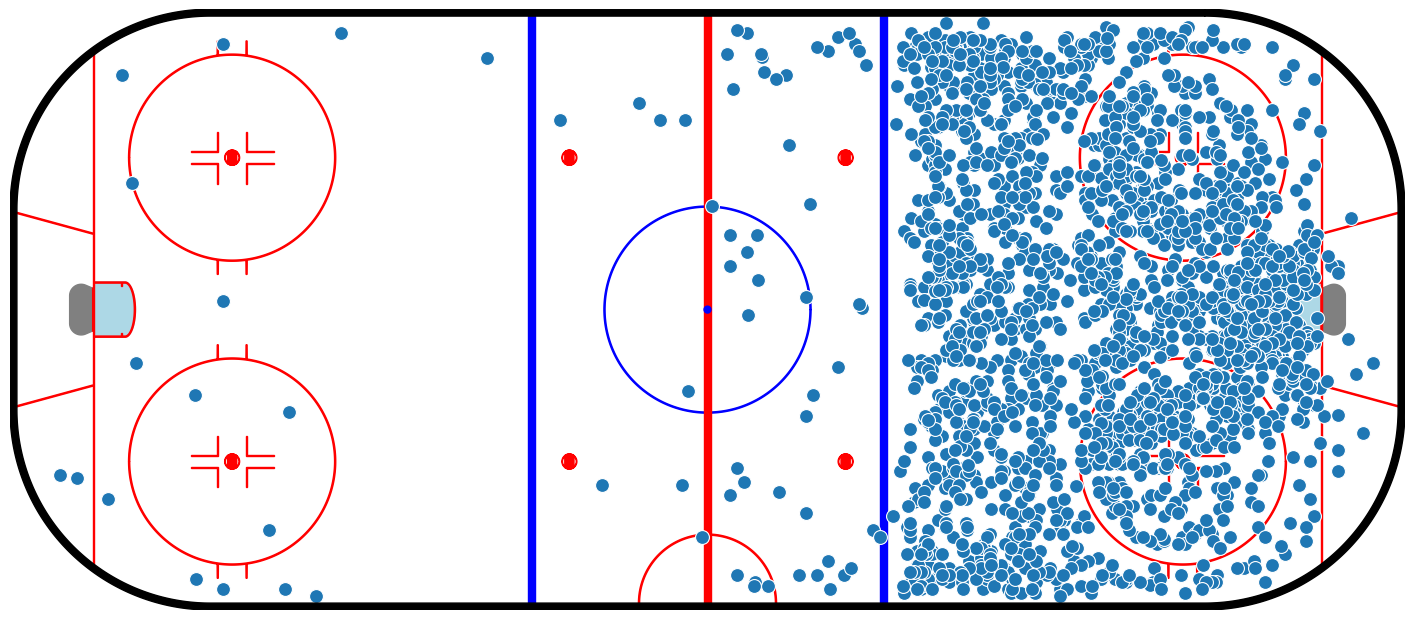

In [133]:
rink = NHLRink()

fig, ax = plt.subplots(figsize=(18, 8))
rink.plot_fn(sns.scatterplot, x="xadjcoord", y="yadjcoord", s=100, legend=False, data=df_games[df_games.eventname == 'shot'], ax=ax)
plt.show()

In [134]:
df_goalie_passes.outcome.value_counts()

successful      343
failed           70
undetermined      1
Name: outcome, dtype: int64

In [135]:
df_games_goalie_events[df_games_goalie_events.eventname == 'pass'].shape, df_games[df_games.eventname == 'pass'].shape

((414, 23), (17455, 23))

## Creating new attributes

What should be part of move actions? 

- pass, end_event: reception
- loose puck recovery (lpr), end event: next event
- carry, end event: next event
- dumpin, end: next event: 
- dumpout, end: next event
- shot
- check
- faceoff, end event: lpr
- rebound

end events:
- reception
- puck protection
- icing
- penalty
- offside

Which actions are "info" events

- controlledexit
- controlledentry (1699)
    - pass 248
    - pass with stretch 42
    - pass offboards 37
    - pass stretch + offboards 23
- block
- save
- assist
- goal

drop 
- soshot
- sogoal
- penaltydrawn
- controlledentryagainst


In [136]:
df_games['outcome_code'] = df_games.outcome.astype('category').cat.codes

In [137]:
df_games.loc[(df_games.eventname == "faceoff") & (df_games.outcome_code == 0), 'eventname'] = 'faceoff_lost'

In [138]:
df_games.loc[df_games.shift(-1).eventname == 'controlledexit', 'is_exit'] = 1
df_games['is_exit'].fillna(0, inplace=True)
df_games.loc[df_games.shift(-1).eventname == 'controlledentry', 'is_entry'] = 1
df_games['is_entry'].fillna(0, inplace=True)
df_games.loc[df_games.shift(-1).eventname == 'block', 'is_blocked'] = 1
df_games['is_blocked'].fillna(0, inplace=True)
df_games.loc[df_games.shift(-1).eventname == 'save', 'is_saved'] = 1
df_games['is_saved'].fillna(0, inplace=True)
df_games.loc[df_games.shift(-1).eventname == 'assist', 'is_assist'] = 1
df_games['is_assist'].fillna(0, inplace=True)
df_games.loc[df_games.shift(-1).eventname == 'goal', 'is_goal'] = 1
df_games['is_goal'].fillna(0, inplace=True)

In [139]:
df_games.head()

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg,compiledgametime,eventname,ishomegame,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord,eventid,outcome_code,is_exit,is_entry,is_blocked,is_saved,is_assist,is_goal
0,66445,506563.0,916,358235,940804.0,742,NaN,NaN,NaN,0.000000,faceoff_lost,1,evenStrength,5,failed,1,F,0,5,none,0.305008,-0.252941,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,66445,940804.0,742,586302,506563.0,916,NaN,NaN,NaN,0.000000,faceoff,0,evenStrength,5,successful,1,F,0,5,recoveredwithentry,-0.305008,0.252941,1,1,0.0,0.0,0.0,0.0,0.0,0.0
2,66445,506563.0,916,358235,940804.0,742,NaN,NaN,NaN,0.033333,lpr,1,evenStrength,5,failed,1,F,0,5,contested,-0.197929,0.752941,2,0,0.0,0.0,0.0,0.0,0.0,0.0
3,66445,940804.0,742,689086,506563.0,916,916.0,0.0,NaN,0.100000,lpr,0,evenStrength,5,successful,1,D,0,5,faceoff,-7.849129,-4.776470,3,1,0.0,0.0,0.0,0.0,0.0,0.0
4,66445,940804.0,742,689086,506563.0,916,916.0,0.0,NaN,0.166667,pass,0,evenStrength,5,successful,1,D,0,5,south,-6.843246,-3.267647,4,1,0.0,0.0,0.0,0.0,0.0,0.0


## Identifying end location of passes

In [140]:
df_games['next_event'] = df_games.shift(-1, fill_value='end')['eventname']
df_games['interruption'] = df_games.apply(lambda x: 1 if ((x['next_event'] == 'icing') | (x['next_event'] == 'penalty') | (x['next_event'] == 'offside'))   else 0, axis=1)
df_games['next_teamid'] = df_games.shift(-1, fill_value=0)['teamid']
df_games['next_teaminpossession'] = df_games.shift(-1)['teaminpossession']
df_games['prev_event'] = df_games.shift(1, fill_value='start')['eventname']

In [141]:
df_games.loc[~df_games['eventname'].isin(['controlledentry', 'controlledexit', 'goal', 'shot', 'assist', 'soshot', 'sogoal', 'sopuckprotection', 'faceoff_lost']), 'xadjcoord_end'] = df_games.loc[~df_games['eventname'].isin(['controlledentry', 'controlledexit', 'goal', 'shot', 'assist', 'soshot', 'sogoal', 'sopuckprotection', 'faceoff_lost']), 'xadjcoord'].shift(-1)
df_games.loc[~df_games['eventname'].isin(['controlledentry', 'controlledexit', 'goal', 'shot', 'assist', 'soshot', 'sogoal', 'sopuckprotection', 'faceoff_lost']), 'yadjcoord_end'] = df_games.loc[~df_games['eventname'].isin(['controlledentry', 'controlledexit', 'goal', 'shot', 'assist', 'soshot', 'sogoal', 'sopuckprotection', 'faceoff_lost']), 'yadjcoord'].shift(-1)

In [142]:
# adjust coordinates to be in the same direction all the time
df_games.loc[(df_games['next_teamid'] != df_games['teamid']) & (~df_games['eventname'].isin(['controlledentry', 'controlledexit', 'goal', 'shot', 'assist', 'soshot', 'sogoal', 'sopuckprotection', 'faceoff_lost'])), 'yadjcoord_end'] = df_games.loc[(df_games['next_teamid'] != df_games['teamid']) & (~df_games['eventname'].isin(['controlledentry', 'controlledexit', 'goal', 'shot', 'assist', 'soshot', 'sogoal', 'sopuckprotection', 'faceoff_lost'])), 'yadjcoord_end'].mul(-1)
df_games.loc[(df_games['next_teamid'] != df_games['teamid']) & (~df_games['eventname'].isin(['controlledentry', 'controlledexit', 'goal', 'shot', 'assist', 'soshot', 'sogoal', 'sopuckprotection', 'faceoff_lost'])), 'xadjcoord_end'] = df_games.loc[(df_games['next_teamid'] != df_games['teamid']) & (~df_games['eventname'].isin(['controlledentry', 'controlledexit', 'goal', 'shot', 'assist', 'soshot', 'sogoal', 'sopuckprotection', 'faceoff_lost'])), 'xadjcoord_end'].mul(-1)

In [143]:
df_games.loc[df_games.eventname.isin(["pass"]) & (df_games.outcome_code == 1), 'xadjcoord_end'] = df_games.loc[df_games.eventname.isin(['reception']) & (df_games.outcome_code == 1), 'xadjcoord'].to_list()
df_games.loc[df_games.eventname.isin(["pass"]) & (df_games.outcome_code == 1), 'yadjcoord_end'] = df_games.loc[df_games.eventname.isin(['reception']) & (df_games.outcome_code == 1), 'yadjcoord'].to_list()

In [144]:
df_games.loc[df_games.eventname.isin(["pass", 'reception']) & (df_games.outcome_code == 1), ['eventname', 'teamid', 'xadjcoord', 'yadjcoord', 'xadjcoord_end', 'yadjcoord_end']].head(20)

,eventname,teamid,xadjcoord,yadjcoord,xadjcoord_end,yadjcoord_end
4,pass,916,-6.843246,-3.267647,-23.943245,7.294117
5,reception,916,-23.943245,7.294117,-21.428535,7.797058
6,pass,916,-21.428535,7.797058,-29.475601,-18.355881
7,reception,916,-29.475601,-18.355881,-24.949127,-24.894119
10,pass,916,-22.434418,-32.438232,21.321465,-39.982353
11,reception,916,21.321465,-39.982353,20.818520,-39.479408
18,pass,742,-93.242050,25.900002,-91.733223,25.397057
19,reception,742,-91.733223,25.397057,-93.744987,24.391174
20,pass,742,-93.744987,24.391174,-96.259697,15.841175
21,reception,742,-96.259697,15.841175,-89.721458,-32.441177


In [145]:
df_games.head(20)

,gameid,opposingteamgoalieoniceid,opposingteamid,playerid,teamgoalieoniceid,teamid,teaminpossession,currentpossession,xg,compiledgametime,eventname,ishomegame,manpowersituation,opposingteamskatersonicecount,outcome,period,playerprimaryposition,scoredifferential,teamskatersonicecount,type,xadjcoord,yadjcoord,eventid,outcome_code,is_exit,is_entry,is_blocked,is_saved,is_assist,is_goal,next_event,interruption,next_teamid,next_teaminpossession,prev_event,xadjcoord_end,yadjcoord_end
0,66445,506563.0,916,358235,940804.0,742,NaN,NaN,NaN,0.000000,faceoff_lost,1,evenStrength,5,failed,1,F,0,5,none,0.305008,-0.252941,0,0,0.0,0.0,0.0,0.0,0.0,0.0,faceoff,0,916,NaN,start,NaN,NaN
1,66445,940804.0,742,586302,506563.0,916,NaN,NaN,NaN,0.000000,faceoff,0,evenStrength,5,successful,1,F,0,5,recoveredwithentry,-0.305008,0.252941,1,1,0.0,0.0,0.0,0.0,0.0,0.0,lpr,0,742,NaN,faceoff_lost,0.197929,-0.752941
2,66445,506563.0,916,358235,940804.0,742,NaN,NaN,NaN,0.033333,lpr,1,evenStrength,5,failed,1,F,0,5,contested,-0.197929,0.752941,2,0,0.0,0.0,0.0,0.0,0.0,0.0,lpr,0,916,916.0,faceoff,7.849129,4.776470
3,66445,940804.0,742,689086,506563.0,916,916.0,0.0,NaN,0.100000,lpr,0,evenStrength,5,successful,1,D,0,5,faceoff,-7.849129,-4.776470,3,1,0.0,0.0,0.0,0.0,0.0,0.0,pass,0,916,916.0,lpr,-6.843246,-3.267647
4,66445,940804.0,742,689086,506563.0,916,916.0,0.0,NaN,0.166667,pass,0,evenStrength,5,successful,1,D,0,5,south,-6.843246,-3.267647,4,1,0.0,0.0,0.0,0.0,0.0,0.0,reception,0,916,916.0,lpr,-23.943245,7.294117
5,66445,940804.0,742,591556,506563.0,916,916.0,0.0,NaN,1.000000,reception,0,evenStrength,5,successful,1,D,0,5,regular,-23.943245,7.294117,5,1,0.0,0.0,0.0,0.0,0.0,0.0,pass,0,916,916.0,pass,-21.428535,7.797058
6,66445,940804.0,742,591556,506563.0,916,916.0,0.0,NaN,2.600000,pass,0,evenStrength,5,successful,1,D,0,5,south,-21.428535,7.797058,6,1,0.0,0.0,0.0,0.0,0.0,0.0,reception,0,916,916.0,reception,-29.475601,-18.355881
7,66445,940804.0,742,689086,506563.0,916,916.0,0.0,NaN,3.300000,reception,0,evenStrength,5,successful,1,D,0,5,regular,-29.475601,-18.355881,7,1,0.0,0.0,0.0,0.0,0.0,0.0,carry,0,916,916.0,pass,-24.949127,-24.894119
8,66445,940804.0,742,689086,506563.0,916,916.0,0.0,NaN,3.633333,carry,0,evenStrength,5,successful,1,D,0,5,none,-24.949127,-24.894119,8,1,1.0,0.0,0.0,0.0,0.0,0.0,controlledexit,0,916,NaN,reception,-22.434418,-32.438232
9,66445,940804.0,742,689086,506563.0,916,NaN,NaN,NaN,3.633333,controlledexit,0,evenStrength,5,successful,1,D,0,5,carrywithplay,-24.949127,-24.894119,9,1,0.0,0.0,0.0,0.0,0.0,0.0,pass,0,916,916.0,carry,NaN,NaN


In [161]:
df_move = df_games.loc[df_games.eventname.isin(['pass', 'carry'])].copy()

In [164]:
df_move.to_csv("data/Linhac_df_move.csv", index=True)

In [165]:
df_games.to_csv("data/Linhac_df_processed.csv", index=True)